# Movielens 영화 추천🎬

__프로젝트 목표__<br>
- 추천시스템의 개념과 목적을 이해한다.
- Implicit 라이브러리를 활용하여 Matrix Factorization(이하 MF) 기반의 추천 모델을 만들어 본다.
- 영화 시청 기록을 활용하여 비슷한 영화를 찾고 사용자에 따른 영화를 추천해 본다.
- 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 익힌다
- 유저의 행위 데이터 중 Explicit data와 Implicit data의 차이점을 익힌다.

In [1]:
import os
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

## 1. 데이터 준비와 전처리

사용할 데이터셋은 Movielens 데이터이다.

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 존재한다
- 별점 데이터는 대표적인 explicit 데이터이나, implicit 데이터로 간주하고 테스트한다.
- 별점을 시청횟수로 해석해서 생각한다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외한다.

In [2]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# ratings 와 movies 데이터 프레임 합치기
data = ratings.join(movies.set_index('movie_id'), on='movie_id')
data.head()

,user_id,movie_id,count,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [7]:
# user_id가 1인 사용자가 어떤 영화를 시청했는지 확인해봅니다.
movie_id_user1 = data[data['user_id']== 1]['title']
movie_id_user1

0                One Flew Over the Cuckoo's Nest (1975)
1                      James and the Giant Peach (1996)
2                                   My Fair Lady (1964)
3                                Erin Brockovich (2000)
4                                  Bug's Life, A (1998)
5                            Princess Bride, The (1987)
6                                        Ben-Hur (1959)
7                             Christmas Story, A (1983)
8                Snow White and the Seven Dwarfs (1937)
9                              Wizard of Oz, The (1939)
10                          Beauty and the Beast (1991)
11                                          Gigi (1958)
12                        Miracle on 34th Street (1947)
13                      Ferris Bueller's Day Off (1986)
14                           Sound of Music, The (1965)
15                                     Airplane! (1980)
16                                        Tarzan (1999)
17                                         Bambi

## 2. 데이터 탐색하기

- ratings에 있는 유니크한 영화 개수
- rating에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [8]:
# 영화 개수
print('영화 개수: ', data['movie_id'].nunique())

영화 개수:  3628


In [9]:
# 사용자 수
print('사용자 수: ', data['user_id'].nunique())

사용자 수:  6039


In [10]:
# 인기있는 영화 Top 30
print('인기있는 영화 Top 30')
movie_count = data.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

인기있는 영화 Top 30


title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [11]:
# 유저별 몇 편의 영화를 시청했는지에 대한 통계
user_count = data.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [12]:
# 영화 별 시청(count)횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['count'].median()
user_median.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: count, dtype: float64

## 3. 모델 검증을 위한 사용자 초기 정보 세팅
내가 선호하는 영화를 5가지 골라서 rating에 추가해준다. 예측값 해석을 용이하게 하기 위해 애니메이션 장르의 영화 5개를 초기 정보값으로 입력해 주었다.

In [51]:
# 영화 제목 키워드로 검색
movies[movies['title'].str.lower().str.contains('english ', regex=False)]

,movie_id,title,genre
1166,1183,"English Patient, The (1996)",Drama|Romance|War
1484,1519,Broken English (1996),Drama


In [14]:
# 좋아하는 영화의 id 리스트
my_favoite_id = [1, 2294, 1566, 588, 1907]

# id 리스트를 title 리스트로 변환해준다
my_favorite_movie = []
for mid in my_favoite_id:
    my_favorite_movie.append(list(movies[movies['movie_id']==mid]['title'])[0])
    
# '6041'6이라는 user_id가 위 영화를 5회씩 시청했다고 가정하겠습니다.
my_watchlist = pd.DataFrame({'user_id': ['6041']*5, 'movie_id': my_favoite_id, 'title': my_favorite_movie, 'count':[5]*5})

if not data.isin({'user_id':['6041']})['user_id'].any():  # user_id에 'eunyoeng'이라는 데이터가 없다면
    data = data.append(my_watchlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data = data[['user_id', 'movie_id', 'title', 'count']]
data.tail()

,user_id,movie_id,title,count
0,6041,1,Toy Story (1995),5
1,6041,2294,Antz (1998),5
2,6041,1566,Hercules (1997),5
3,6041,588,Aladdin (1992),5
4,6041,1907,Mulan (1998),5


## 4. CSR(Compressed Sparse Row) Matrix 만들기

![csr matrix](https://lovit.github.io/assets/figures/sparse_matrix_csr.png)
출처:https://lovit.github.io/nlp/machine%20learning/2018/04/09/sparse_mtarix_handling/#csr-matrix

CSR Matrix는 sparse한 matrix에서 유효한 데이터의 값과 과표 정보만으로 구성되어 메모리 사용량을 최소화할 수 있는 데이터 구조이다. row 순서대로 데이터를 저장한다.

In [15]:
# 고유한 유저, 영화를 찾기
user_unique = data['user_id'].unique()
movie_unique = data['title'].unique()

In [16]:
# 유저, 영화 indexing
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [17]:
# 데이터 컬럼 내 값을 indexing된 값으로 교체

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['new_user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')
    
# movie_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = data['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(data):
    print('title column indexing OK!!')
    data['new_movie_id'] = temp_movie_data
else:
    print('movie_id column indexing Fail!!')

data

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,title,count,new_user_id,new_movie_id
0,1,1193,One Flew Over the Cuckoo's Nest (1975),5,0,0
1,1,661,James and the Giant Peach (1996),3,0,1
2,1,914,My Fair Lady (1964),3,0,2
3,1,3408,Erin Brockovich (2000),4,0,3
4,1,2355,"Bug's Life, A (1998)",5,0,4
...,...,...,...,...,...,...
0,6041,1,Toy Story (1995),5,6039,40
1,6041,2294,Antz (1998),5,6039,30
2,6041,1566,Hercules (1997),5,6039,32
3,6041,588,Aladdin (1992),5,6039,33


In [18]:
# CSR Matrix 생성
num_user = data['new_user_id'].nunique()
num_movie = data['new_movie_id'].nunique()

# csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
csr_data = csr_matrix((data['count'], (data.new_user_id, data.new_movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

## 5. MF 모델 학습하기

![Fast and Scalable Matrix Factorization](https://d3s0tskafalll9.cloudfront.net/media/images/E-3v2-2_ekCv9hW.max-800x600.png)
출처:https://arxiv.org/pdf/1610.05838.pdf

- (m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R은 P와 Q의 행렬곱으로 표현 가능할 수 있다.
- 이때의 P와 Q는 Feature Matrix
- 영화를 추천하는 모델에 대입한다면, 사용자의 특성(Feature) 벡터인 P, 영화의 특성 벡터인 Q로 볼 수 있고 두 벡터를 내적해서 얻어지는 R이 사용자의 영화 선호도를 보는 것
- k는 m,n보다 작은 값이기 때문에 계산량 측면으로도 훨씬 유리하다.
- MF 모델은 성능이 준수하고 Scalability가 좋아서 많이 사용된다.

- 모델의 **목표**는 모든 유저와 아이템에 대해  **k-dimension의 벡터를 잘 만드는 것**
- 벡터를 잘 만든다는 기준은 유저i의 벡터$U_i$와 아이템j의 벡터$I_j$를 내적했을 때 유저i가 아이템j에 대해 평가한 수치$M_ij$와 비슷한가이다.
$$U_i*I_j=M_{ij}$$

***

Matrix Factorization 모델을 implicit 패키지를 사용하여 학습해 본다.
- `implicit` 패키지는 implicit dataset을 사용하는 다양한 모델을 빠르게 학습할 수 있는 패키지
- `als(AlternatingLeastSquares) model`: MF에서 두 Feature Matrix를 한번에 훈련하는 것은 잘 수렴하지 않아, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 방식(AlternatingLeastSquares)이 효과적이다.
>__Implicit Datasets__<br>
Implicit Data는 유저가 간접적(Implicit)으로 선호, 취향을 나타내는 데이터를 의미한다. 예시로는 검색 기록, 방문 페이지, 구매 내역 등이 있다
    
    출처: https://orill.tistory.com/entry/Explicit-vs-Implicit-Feedback-Datasets?category=1066301

In [19]:
# implicit 라이브러리에서 권장하고 있는 세팅
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

__AlternatingLeastSquares__ 클래스의 **\_\_init\_\_ 파라미터**를 살펴보면,

1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지 
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지 
3. use_gpu : GPU를 사용할 것인지 
4. iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

1,4를 늘릴수록 학습을 잘 하게 되지만 과적합의 우려가 있다.

In [20]:
AlternatingLeastSquares.__init__

<function implicit.als.AlternatingLeastSquares.__init__(self, factors=100, regularization=0.01, dtype=<class 'numpy.float32'>, use_native=True, use_cg=True, use_gpu=False, iterations=15, calculate_training_loss=False, num_threads=0, random_state=None)>

### 모델 설계

In [21]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)

In [22]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

### 모델 학습

In [23]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/20 [00:00<?, ?it/s]

## 6. 결과 확인

### 6-1. 영화 선호도 파악하기

In [24]:
eunyeong, mulan = user_to_idx['6041'], movie_to_idx['Mulan (1998)']
eunyeong_vector, mulan_vector = als_model.user_factors[eunyeong], als_model.item_factors[mulan]

In [25]:
eunyeong_vector # 나의 사용자 벡터

array([-0.02651836, -0.32261422, -0.22656272,  0.41848746, -0.63098246,
       -0.40613934,  0.15849115,  0.17943887,  0.2960535 ,  0.1503299 ,
       -0.11008499,  0.3787967 , -0.22134264, -0.37247333, -0.8027481 ,
        0.18460505,  0.60743886, -0.2789573 ,  0.00968763,  0.4532709 ,
        0.19175573, -0.23922448,  0.47254458,  0.46992213, -0.1658966 ,
       -0.3459084 ,  0.17316577, -0.54285645,  0.51116884,  0.06958477,
       -0.02090974,  0.49625254,  0.26293573,  0.6111128 , -0.37499815,
       -0.16596475,  0.5389047 , -0.03437606, -0.3600217 ,  0.12816498,
       -0.1850889 , -0.0707109 , -0.08358204,  0.0487445 , -0.19351631,
        0.47655082, -0.24719447, -0.27171072,  0.511615  ,  0.4338859 ,
       -0.16637062,  0.928505  ,  0.23089571, -0.11596956,  0.01475885,
       -0.3360982 ,  0.00347733, -0.0943657 , -0.33658054,  0.14959477,
       -0.38512838, -0.04933478, -0.0117647 , -0.13889939,  1.1659265 ,
        0.95981264, -0.04724602, -0.02381607,  0.279917  , -0.42

In [26]:
mulan_vector # 영화 뮬란의 벡터

array([ 1.81849592e-03,  4.80828388e-03,  9.28055216e-03,  1.84755512e-02,
        1.11160196e-04,  3.32128140e-03,  1.06173260e-02,  7.52274122e-04,
       -5.93188778e-03,  2.37716897e-03, -2.78835854e-04,  9.91005823e-03,
        1.72225647e-02,  8.91456939e-03, -3.05081997e-02,  1.22858835e-02,
        2.22746171e-02,  9.71779693e-03,  8.16260278e-03,  1.33153955e-02,
        3.17045185e-03, -1.97088416e-03,  1.22168502e-02,  1.88700873e-02,
       -1.03791282e-02, -1.10949669e-02,  6.89681666e-03, -1.42777041e-02,
        1.74110159e-02,  1.12375626e-02,  2.82779103e-03,  1.28789498e-02,
        1.15250675e-02,  1.93215255e-02,  2.17331457e-03,  2.06251745e-03,
        8.50532483e-03,  1.10619375e-02,  5.47457021e-03, -5.76784229e-03,
       -5.16748149e-03,  3.33372480e-03,  1.58949476e-02, -4.75158263e-03,
       -7.61701586e-03,  1.28713520e-02, -2.05325931e-02,  6.00214256e-03,
        8.44523776e-03,  1.21211272e-03, -2.88846553e-03,  1.65639743e-02,
        3.48075619e-03,  

In [27]:
# 나와 뮬란의 내적 구하기 (선호 리스트에 있는 영화)
np.dot(eunyeong_vector, mulan_vector)

0.6081663

In [28]:
# 모델이 나의 titanic 대한 선호도를 어떻게 예측하는지 확인(선호 리스트에 없는 영화)
titanic = movie_to_idx['Titanic (1997)']
titanic_vector = als_model.item_factors[titanic]
np.dot(eunyeong_vector, titanic_vector)

0.12802732

In [29]:
# 모델이 나의 Bug's Life대한 선호도를 어떻게 예측하는지 확인
bugs_life = movie_to_idx["Bug's Life, A (1998)"]
bugs_life_vector = als_model.item_factors[bugs_life]
np.dot(eunyeong_vector, bugs_life_vector)

0.51062787

In [30]:
# 모델이 나의 Matrix 대한 선호도를 어떻게 예측하는지 확인
matrix = movie_to_idx['Matrix, The (1999)']
matrix_vector = als_model.item_factors[matrix]
np.dot(eunyeong_vector, matrix_vector)

0.0024028323

선호하는 영화 리스트에 있는 `Mulan`에 대한 선호도는 0.60정도이다.
`Bugs' Life`에 대한 예측된 선호도는 0.51정도로
`Matrix` 나 `Titanic`에 대한 예측값이 0.13, 0.002인것을 보면 높은 선호도를 보일 것이라 예측 해준다. 
사용자 초기 정보 세팅할 때 선호하는 영화 5개를 모두 장르가 _Animation\|Children's_  속하는 영화로  넣어주었기 때문에, 나는 애니메이션을 매우 좋아하는 사용자라고 학습되었고, 그 결과 애니메이션 장르인 `Bug's Life`는 높은 선호도를 가질 것이라 예측 해준것 같다.
_Drama\|Romance_  장르인 `Titanic` 보다 _Action\|Sci-Fi\|Thriller_ 장르인 `Matrix`의 선호도가 낮을 거라 예측해준 것도 흥미롭다.

### 6-2. 내가 좋아하는 영화와 비슷한 영화 추천

`AlternatingLeastSquares` 클래스에 구현되어 있는 `similar_items` 메서드를 통하여 비슷한 영화를 찾는다.

In [31]:
def get_similar_artist(movie_title: str):
    movie_id = movie_to_idx[movie_title]
    similar_movie = als_model.similar_items(movie_id)
    idx_to_movie = {v:k for k,v in movie_to_idx.items()}
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [32]:
get_similar_artist('Mulan (1998)')

['Mulan (1998)',
 'Tarzan (1999)',
 'Hunchback of Notre Dame, The (1996)',
 'Hercules (1997)',
 'Antz (1998)',
 'Rescuers Down Under, The (1990)',
 'Anastasia (1997)',
 'Beauty and the Beast (1991)',
 'Balto (1995)',
 'Lion King, The (1994)']

In [33]:
get_similar_artist('Titanic (1997)')

['Titanic (1997)',
 "You've Got Mail (1998)",
 'Jerry Maguire (1996)',
 'Ever After: A Cinderella Story (1998)',
 'Walking Dead, The (1995)',
 'English Patient, The (1996)',
 'Snow Day (2000)',
 'Bridges of Madison County, The (1995)',
 'Paris, France (1993)',
 'Mr. & Mrs. Smith (1941)']

In [34]:
get_similar_artist('Matrix, The (1999)')

['Matrix, The (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Total Recall (1990)',
 'Fugitive, The (1993)',
 'Fifth Element, The (1997)',
 'Terminator, The (1984)',
 'Face/Off (1997)',
 'Men in Black (1997)',
 'Twelve Monkeys (1995)',
 'Surviving Picasso (1996)']

### 6-3. 내가 좋아할 만한 영화는?

In [35]:
user = user_to_idx['6041']

# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)

# 인덱스를 영화 제목으로 변환
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
recommend_movies = [idx_to_movie[i[0]] for i in movie_recommended]
recommend_movies

['Lion King, The (1994)',
 'Beauty and the Beast (1991)',
 "Bug's Life, A (1998)",
 'Tarzan (1999)',
 'Toy Story 2 (1999)',
 'Hunchback of Notre Dame, The (1996)',
 'Iron Giant, The (1999)',
 'Anastasia (1997)',
 'Babe (1995)',
 'Little Mermaid, The (1989)',
 'James and the Giant Peach (1996)',
 'Pocahontas (1995)',
 'Nightmare Before Christmas, The (1993)',
 'Prince of Egypt, The (1998)',
 '101 Dalmatians (1961)',
 'Santa Clause, The (1994)',
 'English Patient, The (1996)',
 'Secret of NIMH, The (1982)',
 'Aladdin and the King of Thieves (1996)',
 'Bambi (1942)']

추천된 영화가 대부분 `Animation`이나 `Children's` 장르의 영화로 성향을 잘 파악하고 추천해 주는 것을 확인 할 수 있다. `Toy Story`와 `Aladdin`을 선호하는 영화로 입력해줬는데 시리즈물인 `Toy Story 2`와 `Aladdin and the King of Thieves`가 추천되는 점은 신뢰성을 높여주는 결과라 생각된다. 추천된 영화들 중에 유일하게 장르가 다른 영화는 `English Patient`인데 찾아보니 전쟁영화이면서 로맨스 물이라 한다. 예고편을 보는 정도로는 다른 영화들과의 공통점을 찾을 수 없었다. 결과를 잘 해석하기 위해서 도메인 지식이 요구된다는 점을 다시 상기할 수 있었다.

__모델들은 왜 Lion King을 가장 추천해 주었을까?__<br>
AlternatingLeastSquares 클래스에 구현된 explain 메소드를 사용하면 기록을 남긴 데이터 중 이 추천에 기여한 정도를 확인할 수 있다.

In [36]:
lionking = movie_to_idx['Lion King, The (1994)']
explain_lionking = als_model.explain(user, csr_data, itemid=lionking)

# 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됩니다.)
[(idx_to_movie[i[0]], i[1]) for i in explain_lionking[1]]

[('Aladdin (1992)', 0.2412715061312232),
 ('Antz (1998)', 0.11178395585543138),
 ('Mulan (1998)', 0.1016707111583918),
 ('Hercules (1997)', 0.07121596127497602),
 ('Toy Story (1995)', 0.06312665311724185)]

알라딘이 같은 장르에 뮤지컬, 로맨스 등의 요소들이 함께 있어 가장 많은 영향을 끼친 것일까.?

In [48]:
english_patient = movie_to_idx['English Patient, The (1996)']
explain_english_patient = als_model.explain(user, csr_data, itemid=english_patient)

# 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됩니다.)
[(idx_to_movie[i[0]], i[1]) for i in explain_english_patient[1]]

[('Antz (1998)', 0.06060928221766998),
 ('Aladdin (1992)', 0.04532519544562793),
 ('Hercules (1997)', 0.03022720951888227),
 ('Toy Story (1995)', 0.027366333920500505),
 ('Mulan (1998)', -0.002571804179136275)]

#### English Patient가 왜 추천되었을까?

In [80]:
ep = data[data['movie_id']==1183] # english patient 영화를 본사람
ep2 = df[df['count']>3]# 그중 점수 4점 이상을 준사람 =  그영화를 좋아하는 사람
user_unique_ep = ep2['user_id'].unique() # eglish patient의 팬인 사람의 고유 id

user_unique_ep = list(user_unique_ep)
len(user_unique_ep)

580

In [83]:
# eglish patient의 팬들의 ratings 기록
df_fans = data[data['user_id'].isin(user_unique_ep)]
df_fans

,user_id,movie_id,title,count,new_user_id,new_movie_id
5420,38,648,Mission: Impossible (1996),3,37,58
5421,38,2485,She's All That (1999),3,37,789
5422,38,141,"Birdcage, The (1996)",3,37,790
5423,38,215,Before Sunrise (1995),3,37,213
5424,38,1688,Anastasia (1997),3,37,329
...,...,...,...,...,...,...
999738,6038,1296,"Room with a View, A (1986)",5,6036,351
999739,6038,1354,Breaking the Waves (1996),3,6036,2265
999742,6038,2716,Ghostbusters (1984),3,6036,243
999743,6038,3396,"Muppet Movie, The (1979)",3,6036,953


In [90]:
# 장르 정보 추가하기
df_fans = df_fans.join(movies[['movie_id', 'genre']].set_index('movie_id'), on='movie_id')

In [100]:
# english patient의 팬들팬들이 선호하는 장르
df_fans.groupby('genre')['user_id'].count().sort_values(ascending=False).head(30)

genre
Drama                           24928
Comedy                          16231
Comedy|Romance                   7901
Comedy|Drama                     7603
Drama|Romance                    7401
Action|Thriller                  3530
Drama|Thriller                   3154
Drama|War                        3114
Thriller                         2875
Comedy|Drama|Romance             2467
Crime|Drama                      2367
Horror                           2089
Action|Drama|War                 1922
Drama|Romance|War                1880
Action|Adventure|Sci-Fi          1858
Action                           1548
Action|Drama                     1477
Action|Sci-Fi|Thriller           1424
Action|Sci-Fi                    1313
Crime|Thriller                   1295
Mystery|Thriller                 1280
Documentary                      1249
Animation|Children's|Musical     1231
Action|Adventure                 1218
Drama|Mystery                    1188
Animation|Children's             1156
Comedy

In [99]:
# english patient의 팬들팬들이 선호하는 영화
df_fans.groupby('title')['user_id'].count().sort_values(ascending=False).head(30)

title
English Patient, The (1996)                              580
American Beauty (1999)                                   408
Schindler's List (1993)                                  403
Shakespeare in Love (1998)                               400
Fargo (1996)                                             393
Saving Private Ryan (1998)                               387
Silence of the Lambs, The (1991)                         363
L.A. Confidential (1997)                                 361
Forrest Gump (1994)                                      357
Star Wars: Episode V - The Empire Strikes Back (1980)    357
Shawshank Redemption, The (1994)                         353
Groundhog Day (1993)                                     351
Pulp Fiction (1994)                                      345
Braveheart (1995)                                        343
Crying Game, The (1992)                                  328
Star Wars: Episode IV - A New Hope (1977)                328
Star Wars: Episode

..공통점을 찾기가 쉽지않다😭

## 7. 추천시스템 평가

 __Mean Average Precision(MAP)__<br>
추천결과가 추천의도와 관련도가 높은 순으로 잘 나열되어있는지 평가 하는 방법

__Precision and Recall__<br>

|종류|의미|
|:------|:---|
|Precision|우리가 추천한 아이템 중에 사용자가 정말 관심있어야 하는 아이템의 비율|
|Recall|실제로 사용자가 관심있어하는 아이템 중에 우리가 추천한 아이템의 비율|

__Map@K에서 K의 의미__<br>
Precision과 Recall은 순서를 고려하지 않는다. MAP에서는 K라는 값을 설정하여 순서를 고려하는데, 여기서 K의 의미는 추천 리스트의 어디까지 평가할 것인지 결정하는 Index 값이다.

__Avarage Precisoin__
$$AP@K=\frac{1}{m}\sum^K_{i=1}P(i) * rel(i)$$

|종류|의미|
|:-|:-----------|
|P(i)|해당 index까지의 Precision값|
|rel(i)|해당 index에서 user engagement가 일어났는지 여부, 잘 추천되었는지 여부|
|m|실제로 사용자가 engage한 횟수를 의미|

동일한 양의 아이템을 추천에 성공하더라도라고 그 아이템이 더 앞쪽에 배치될 수록 높은 점수를 받는다.

__“Mean” Average Precision__<br>
한 명의 사용자에게 추천한 결과를 평가한 것이 `Average Precision`이고, 사용자 U에 대해 평가를 하는 것이 `Mean Average Precision`이다.
$$MAP@K=\frac{1}{|U|}\sum^{|U|}_{u=1}(AP@K)_u$$

출처:https://danthetech.netlify.app/DataScience/evaluation-metrics-for-recommendation-system

***

추천된 영화들 중 썸네일 및 예고편을 보고 관심있을 만한 영화를 액션을 취했다고 가정하고 평가 해본다.

|Recommend Movie|Action|
|:-|:-----------|
|Lion King The (1994)|🤩|
|Beauty and the Beast (1991)|🤩|
|Bugs Life A (1998)|🤩|
|Tarzan (1999)|🤩|
|Toy Story 2 (1999)|🤩|
|Hunchback of Notre Dame The (1996)|🤩|
|Iron Giant The (1999)|🤢|
|Anastasia (1997)|🤩|
|Babe (1995)|🤢|
|Little Mermaid The (1989)|🤩|
|James and the Giant Peach (1996)|🤢|
|Pocahontas (1995)|🤩|
|Nightmare Before Christmas The (1993)|🤩|
|Prince of Egypt The (1998)|🤢|
|101 Dalmatians (1961)|🤩|
|Santa Clause The (1994)|🤩|
|English Patient The (1996)|🤢|
|Secret of NIMH The (1982)|🤩|
|Aladdin and the King of Thieves (1996)|🤩|
|Bambi (1942)|🤩|

In [43]:
recoms = [1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,1,0,1,1,1]  # N = 20
NUM_ACTUAL_ADDED_ACCT = 15 
precs = []
recalls = []

for indx, rec in enumerate(recoms):
    precs.append(sum(recoms[:indx+1])/(indx+1))
    recalls.append(sum(recoms[:indx+1])/NUM_ACTUAL_ADDED_ACCT)

pd.DataFrame({'precision':precs, 'recall':recalls})

,precision,recall
0,1.000000,0.066667
1,1.000000,0.133333
2,1.000000,0.200000
3,1.000000,0.266667
4,1.000000,0.333333
5,1.000000,0.400000
6,0.857143,0.400000
7,0.875000,0.466667
8,0.777778,0.466667
9,0.800000,0.533333


Text(0.5, 1.0, 'P(i) vs. r(i) for Increasing $i$ for AP@20')

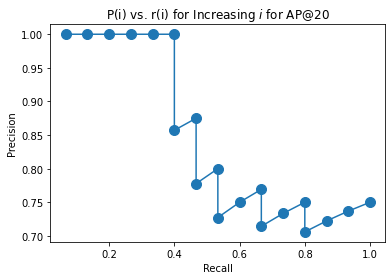

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(recalls, precs, markersize=10, marker="o")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("P(i) vs. r(i) for Increasing $i$ for AP@20")

추천된 6번째 영화까지는 모두 사용자의 액션을 이끌어 냈기 때문에 Precision이 1.0이지만 그 후부터 사용자가 관심갖지 않는 영화가 존재하기 때문에 점점 수치가 낮아지는 것을 볼 수 있다.
recall은 사용자가 관심있어하는 아이템 중에 우리가 추천한 아이템의 비율이기 때문에 k가 증가할 수록 함께 수치가 증가하는 것을 확인할 수 있다.

***

## 프로젝트 정리

- __데이터 전처리__:ratings의 사용자 정보와 movies의 영화 정보가 함께 필요한 경우가 많아 두 데이터 프레임을 합쳐 data라는 데이터 프레임을 만들어 사용하였다. 
- __초기 정보 세팅__: 추천시스템이 추천을 잘 해주는 지 좀더 잘 판단할 수 있도록 초기 정보 세팅을 할 때 좋아하는 영화 장르들을 _animation|musical|childeren's_ 장르로 좁혀 전달하였다.
- 추천 결과를 보면 위 정보를 가지고 내가 애니메이션 장르를 선호한다는 것을 잘 파악하고 있다는 것을 알 수 있었다.
- __csr matrix__: user_id와 movie_id가 숫자로 되어 있어  작업이 필요하지 않을 거라 생각했는데 csr matrix를 만들며 자꾸 오류가 생겨 확인해보니 인덱싱을 새로 해줘야 했다. 
-  __영화 선호도__: 추천 시스템의 결과를 보면 선호리스트에 있는 영화인 `Mulan`의 선호도는 0.60 정도로 가장 높았고, 선호 리스트에 없는 영화들 중 선호하는 애니메이션 장르인 `Bug's Life`의 점수가 약 0.51로 높은 편이었다. _Drama\|Romance_  장르인 `Titanic` 이 0.19 의 선호도를 얻었고 _Action\|Sci-Fi\|Thriller_ 장르인 `Matrix`의 선호도는 0.002로 가장 낮았다. 실제로 애니메이션 장르를 선호하는 나는 로맨스, 드라마 장르를 액션, 스릴러보다 선호하는 편이기 때문에 추천 결과가 굉장히 흥미로웠다. 
- __비슷한 영화 추천__:  기준이 되는 영화와 장르가 같은 영화들이 주로 추천되었다. 
- __좋아할 만한 영화 추천__:  추천 결과가 대부분 `Animation`이나 `Children's` 장르의 영화였다. 입력한 정보를 바탕으로 성향을 잘 파악하고 추천해 주는 것을 확인 할 수 있었다. 대부분의 영화들이 실제로 재밌게 봤던 영화 들이어서 결과가 잘 나왔다고 판단하였다. 특이했던 것은 `English Patient`라는 영화인데, 유일하게 장르가 전쟁물인 영화였다. 
- `English Patient`선호하는 사용자들(평점 4점 이상)이 선호하는 장르는 드라마,코메디, 로맨스, 전쟁물 등이 있고 애니메이션은 딱히 선호하는 장르가 아니다..
- 또 `English Patient`선호하는 사용자들이 많이 본 영화도 English Patient, American Beauty, Schindler's List, Shakespeare in Love 순으로 애니메이션과는 거리가 있어 보인다..추천된 이유를 쉽게 파악 할 수는 없었다..
- 추천된 20개의 영화 중 15개의 영화가 재밌게 봤던 영화이거나 재밌게 볼 수 있을 것 같은 영화였다.
- __Mean Average Precision(MAP)__: 수치적으로 얼마나 잘 추천되었는지 알아보고자 MAP를 이용하여 평가하여 보았다.